# Benchmark signals

In [145]:
import numpy as np
import pandas as pd
from modules.btc_price_data_processing import load_btc_price_data, restrict_datetime_range

In [116]:
%load_ext autoreload
%autoreload 2

## Relative Strength Index (RSI)
- look 14 days in the past
    - look at days with gains and average these
    - look at days with losses and average these
- $RSI = 100 - [100/(1+\text{avg-gain}/\text{avg-loss})$ 
    - alternatively: $RSI = \text{avg-gain} / (\text{avg-gain}+\text{avg-loss})$ 
- asset considered overbought if RSI > 0.7 and oversold if RSI < 0.3

In [208]:
def get_relative_strength_index(lower_cutoff:str, lookback:int=24*14):
    """"
    Relative Strength Index (RSI)
    lookback: number of hours to look back
    lower_cutoff: date where signal time series should start
    """
    # get bitcoin time series
    btc_df = load_btc_price_data()
    # btc_df = restrict_datetime_range(df, btc_df)

    freq = "h"
    dfh = btc_df.groupby(pd.Grouper(key="datetime", freq=freq))["open"].first().to_frame().copy()   

    # cutoff time series
    dfh = dfh.loc[dfh.index>=lower_cutoff]

    # get hourly returns
    dfh.loc[:,f"open_lag_1"] = dfh["open"].shift(periods=-1)
    dfh[f"perf_1"] = (dfh[f"open_lag_1"] - dfh["open"]) / dfh["open"]
    
    # get extra columns with indicator for positive and negative returns
    dfh["is_gain"] = np.where(dfh[f"perf_1"] > 0, 1, 0)
    dfh["is_loss"] = np.where(dfh[f"perf_1"] < 0, 1, 0)

    # rolling mean over gains and losses
    dfh["avg_gain"] = dfh["is_gain"].rolling(f"{lookback}h").sum() / lookback 
    dfh["avg_loss"] = dfh["is_loss"].rolling(f"{lookback}h").sum() / lookback

    # compute rsi
    # dfh["rsi"] = 100 - (100/(1+dfh["rs_raw"]))
    dfh["rsi"] = dfh["avg_gain"] / (dfh["avg_gain"] + dfh["avg_loss"])

    # compute signal
    def get_rsi_signal(row):
        if row["rsi"] > 0.55:
            return -1
        elif row["rsi"] < 0.45:
            return +1
        else:
            return 0

    dfh["rsi_signal"] = dfh.apply(get_rsi_signal, axis=1)
    
    return dfh

In [209]:
df_rsi = get_relative_strength_index(lower_cutoff="2022-01-01")

In [ ]:
df = df_rsi

In [200]:
df["rsi_signal"].value_counts()

rsi_signal
 0    9351
 1     369
-1     265
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

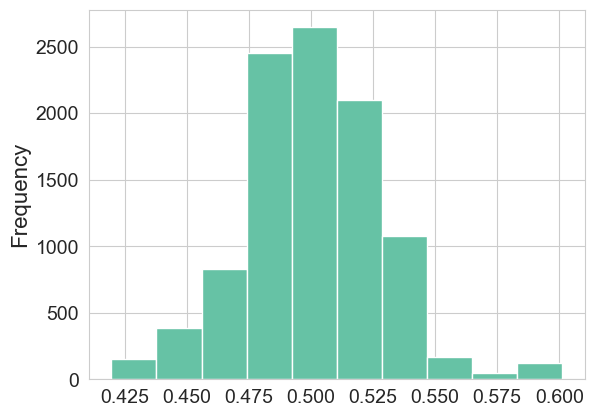

In [201]:
df["rsi"].plot(kind="hist")

In [202]:
df.head()

,open,open_lag_1,perf_1,is_gain,is_loss,avg_gain,avg_loss,rsi,rsi_signal
datetime,,,,,,,,,
2022-01-01 00:00:00,46220.00,46663.14,0.009588,1,0,0.502976,0.497024,0.502976,0
2022-01-01 01:00:00,46663.14,46779.88,0.002502,1,0,0.505952,0.494048,0.505952,0
2022-01-01 02:00:00,46779.88,46810.78,0.000661,1,0,0.505952,0.494048,0.505952,0
2022-01-01 03:00:00,46810.78,46806.83,-0.000084,0,1,0.502976,0.497024,0.502976,0
2022-01-01 04:00:00,46806.83,46712.47,-0.002016,0,1,0.500000,0.500000,0.500000,0


c:\Users\jakob\OneDrive\_SS24\Supervised Research\crypto-nlp\modules\signals.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mean_return_hourly = df['realized'].mean()
c:\Users\jakob\OneDrive\_SS24\Supervised Research\crypto-nlp\modules\signals.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  annualized_mean_return = mean_return_hourly * 8760  # 365 days * 24 hours


(<Figure size 1200x600 with 1 Axes>,
 <Axes: title={'center': 'Cumulative Realized Performance'}, xlabel='Date', ylabel='Cumulative Performance'>)

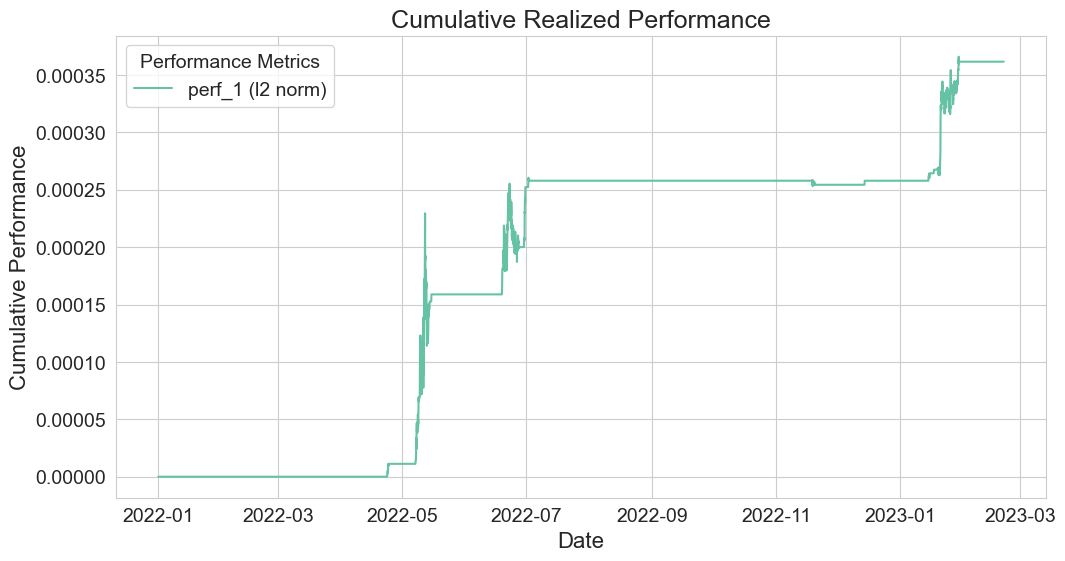

In [203]:
from modules.signals import plot_realization

perfs = [c for c in df.columns if "perf" in c]
plot_realization(df, "rsi_signal", perfs, "l2", threshold=0.9)

In [204]:
from modules.signals import compute_key_metrics

compute_key_metrics(df, "rsi_signal", perfs)

c:\Users\jakob\OneDrive\_SS24\Supervised Research\crypto-nlp\modules\signals.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


{'sharpe': [1.8716440484599257],
 'bias': [-0.000189874221147522],
 'beta': [-0.0007541278650747267]}

## Moving average crossover (MACO)
- compute longer MA (lMA) and shorter MA (sMA) in the past
- return +1 if $sMA > (1+a)lMA$ and -1 if $(1+a)sMA < lMA$ and 0 else (threshold $a \in [0,1]$, default is $a=0$)

In [211]:
def get_moving_average_crossover(lower_cutoff:str, sma:int=24, lma:int=24*7, thres:float=0) -> pd.DataFrame:
    """
    Create Moving Average CrossOver (MACO) signal
    lower_cutoff: date where signal time series should start

    sma: short moving average in hours
    lma: long moving average in hours
    thres: threshold for crossover signal, e.g. thres=0.2 requires sMA > 1.2*lMA for signal = +1 or sMA < 0.8*lMA for signal = -1
    """
    # get bitcoin time series
    btc_df = load_btc_price_data()
    # btc_df = restrict_datetime_range(df, btc_df)

    freq = "h"
    dfh = btc_df.groupby(pd.Grouper(key="datetime", freq=freq))["open"].first().to_frame().copy()   

    # cutoff time series
    dfh = dfh.loc[dfh.index>=lower_cutoff]

    # get moving averages
    dfh["sMA"] = dfh["open"].rolling(f"{sma}h").mean()
    dfh["lMA"] = dfh["open"].rolling(f"{lma}h").mean()

    # get signal
    def get_maco_signal(row):
        if row["sMA"] > (1+thres)*row["lMA"]:
            return +1
        elif row["sMA"] < (1-thres)*row["lMA"]:
            return -1
        else:
            return 0
    dfh["maco_signal"] = dfh.apply(get_maco_signal, axis=1)

    return dfh

In [212]:
df_maco = get_moving_average_crossover(lower_cutoff="2022-01-01", sma=1, lma=5, thres=0)

In [214]:
df = df_maco

In [215]:
df.head()

,open,sMA,lMA,maco_signal
datetime,,,,
2022-01-01 00:00:00,46220.00,46220.00,46220.000,0
2022-01-01 01:00:00,46663.14,46663.14,46441.570,1
2022-01-01 02:00:00,46779.88,46779.88,46554.340,1
2022-01-01 03:00:00,46810.78,46810.78,46618.450,1
2022-01-01 04:00:00,46806.83,46806.83,46656.126,1


<Axes: ylabel='Frequency'>

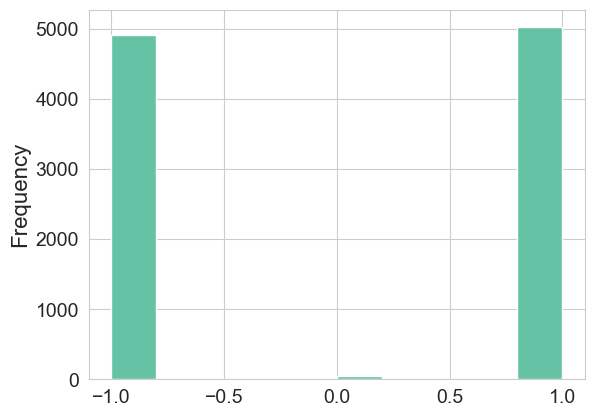

In [216]:
df["maco_signal"].plot(kind="hist")

<Axes: xlabel='datetime'>

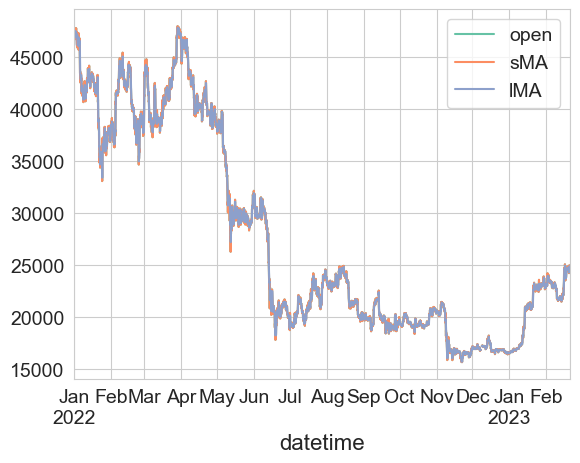

In [108]:
df[["open", "sMA", "lMA"]].plot()

In [109]:
from modules.btc_price_data_processing import add_performance_metrics

df = add_performance_metrics(df.reset_index(), lags=[1])

c:\Users\jakob\OneDrive\_SS24\Supervised Research\crypto-nlp\modules\btc_price_data_processing.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dfh = btc_df.groupby(pd.Grouper(key="datetime", freq=freq))["open"].first().to_frame().copy()


In [110]:
df.head()

,datetime,perf_1,open,sMA,lMA,maco_signal
0,2022-01-01 00:00:00,0.009588,46220.00,46220.00,46093.194,1
1,2022-01-01 01:00:00,0.002502,46663.14,46663.14,46284.288,1
2,2022-01-01 02:00:00,0.000661,46779.88,46779.88,46462.476,1
3,2022-01-01 03:00:00,-0.000084,46810.78,46810.78,46558.816,1
4,2022-01-01 04:00:00,-0.002016,46806.83,46806.83,46656.126,1


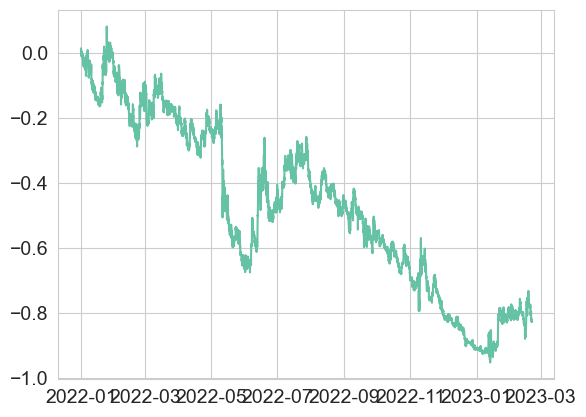

In [140]:
plt.plot(df.datetime, (df["maco_signal"]*df["perf_1"]).cumsum())

(<Figure size 1200x600 with 1 Axes>,
 <Axes: title={'center': 'Cumulative Realized Performance'}, xlabel='Date', ylabel='Cumulative Performance'>)

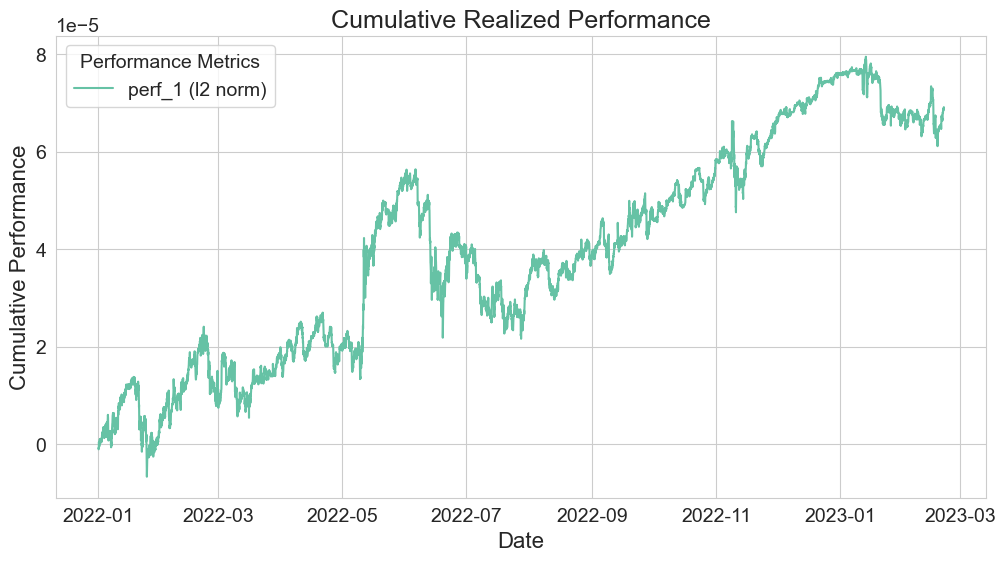

In [133]:
from modules.signals import plot_realization

perfs = [c for c in df.columns if "perf" in c]
plot_realization(df, "maco_signal", perfs, "l2", threshold=0.9)

In [143]:
from modules.signals import compute_key_metrics

compute_key_metrics(df, "maco_signal", perfs)

{'sharpe': [1.1746033603659618],
 'bias': [-8.318675098129215e-05],
 'beta': [-8.340111054409005e-05]}